1. Limpieza y Combinación de Datos

In [13]:
import pandas as pd

# Vamos a estandarizar el titulo en la columna "Title" en ambas fuentes
books_data_df = pd.read_csv('sample_data/books_data.csv')
books_data_df['Title'] = books_data_df['Title'].str.lower().str.replace(' ','_')

#Debido al tamaño del archivo, tuve que subirlo a mi Google Drive y "montarlo" a Collab
books_rating_df = pd.read_csv('drive/MyDrive/project_data/Books_rating.csv', nrows=100000)
books_rating_df['Title'] = books_rating_df['Title'].str.lower().str.replace(' ','_')

# "Combinamos" ambos archivos usando la columna "Title"
combined_df = pd.merge(books_data_df, books_rating_df, on='Title', how='inner')

# Revisamos el Dataset para decidir que columnas son innecesarias para nuestro proyecto
total_rows = combined_df.shape[0]

print('\nTamaño del Dataset')
print(f'- El total de filas es: {total_rows}')
print(f'- El total de columnas es: {combined_df.shape[1]}')
# Revisamos la suma de valores vacios por columna
print('\n\nSuma de vacios (null) para cada columna:')
print(combined_df.isnull().sum())


Tamaño del Dataset
- El total de filas es: 108550
- El total de columnas es: 19


Suma de vacios (null) para cada columna:
Title                     1
description           16847
authors                4631
image                 11865
previewLink            2399
publisher             23068
publishedDate          2990
infoLink               2399
categories            12534
ratingsCount          50646
Id                        0
Price                 95550
User_id               21143
profileName           21147
review/helpfulness        0
review/score              0
review/time               0
review/summary           19
review/text               0
dtype: int64


In [14]:
# Borramos columnas innecesarias
columns_to_drop=['image','previewLink','infoLink', 'publisher', 'publishedDate', 'Price', 'ratingsCount']
combined_df.drop(columns=columns_to_drop, inplace=True)

# Limpiamos las filas que no tienen información (Nulls)
clean_columns = ['Title','description', 'User_id', 'categories', 'authors', 'profileName', 'review/summary']
combined_df.dropna(subset=clean_columns, inplace=True)

total_clean_rows = combined_df.shape[0]
clean_data = (total_clean_rows / total_rows) * 100
print('\n🧹 El Dataset ha sido limpiado correctamente')
print('\nTamaño del Dataset Limpio')
print(f'- El total de filas es: {total_clean_rows}')
print(f'- El total de columnas es: {combined_df.shape[1]}')
print(f'\n El porcentaje de data útil es: {clean_data:.2f}%')

# Revisamos la suma de valores vacios por columna para validar la "limpieza"
print('\n\nSuma de vacios (null) para cada columna:')
print(combined_df.isnull().sum())



🧹 El Dataset ha sido limpiado correctamente

Tamaño del Dataset Limpio
- El total de filas es: 68930
- El total de columnas es: 12

 El porcentaje de data útil es: 63.50%


Suma de vacios (null) para cada columna:
Title                 0
description           0
authors               0
categories            0
Id                    0
User_id               0
profileName           0
review/helpfulness    0
review/score          0
review/time           0
review/summary        0
review/text           0
dtype: int64


2. Preparamos la data para usar TensorFlow.

In [15]:
# Vamos a codificar las etiquetas 'User_id' y 'Title'

from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
book_enc = LabelEncoder()

# Realizamos la codificación transformando las etiquetas en números
combined_df['user_index'] = user_enc.fit_transform(combined_df['User_id'])
combined_df['book_index'] = book_enc.fit_transform(combined_df['Title'])

# Nos aseguramos que los valores de 'review/score' sean números (float)
combined_df['review/score'] = combined_df['review/score'].astype(float)

# Validamos las nuevas columnas
print(combined_df[['User_id', 'user_index', 'Title', 'book_index', 'review/score']].head())

          User_id  user_index                     Title  book_index  \
1  A30TK6U7DNS82R       28463  dr._seuss:_american_icon         960   
2  A3UH4UZ4RSVO82       40110  dr._seuss:_american_icon         960   
3  A2MVUWT453QH61       23044  dr._seuss:_american_icon         960   
4  A22X4XUPKF66MR       15220  dr._seuss:_american_icon         960   
5  A2F6NONFUDB6UK       20002  dr._seuss:_american_icon         960   

   review/score  
1           5.0  
2           5.0  
3           4.0  
4           4.0  
5           4.0  


3. Tokenizamos las Descripciones

In [16]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Configuramos el Tokenizer
vocab_size = 10000 #Asumimos 10,000 palabras frecuentes
max_length = 100 #Asumimos 100 palabras como máximo para la descripción
oov_tok = "<OOV>"

# Creamos el Tokenizer para ser usado con la 'Description'
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(combined_df['description'])

# Convertimos las descripciones en valores números
sequences = tokenizer.texts_to_sequences(combined_df['description'])

# Asignamos una longitud de 100 palabras (Padding)
padded_descriptions = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Validación del proceso
print(f'\nTexto Original: {combined_df['description'].iloc[0][:50]}...')
print(f'\nSecuencia Convertida: {padded_descriptions[0]}')
# Verificamos que los datos tienen el tamaño correcto:
print('\nEl tamaño de la nueva Descripción sea el correcto:')
print(f'\n- Número de Filas: {padded_descriptions.shape[0]}')
print(f'- Longitud de la fila: {padded_descriptions.shape[1]}')


Texto Original: Philip Nel takes a fascinating look into the key a...

Secuencia Convertida: [5569    1  208    5 1126  686   44    2  356 1170    3 7044  609   13
 1659 1227  116 3429    4  167    7    2 1137 2607    1 2914    1   16
  897 4974    8   24    3    2   59  987 4776    7  220   13 4740 5785
  162   16    3  481    1    4 5570    1   26 1575  624  340 2312  193
   25  947  162    1    4 7044    1    1 4230  924  103    1 1475    9
 5678    1    1   26   62 4531  331 2303 2024  162    1 2158    1    4
 8327    1  525   20  396 1382    0    0    0    0    0    0    0    0
    0    0]

El tamaño de la nueva Descripción sea el correcto:

- Número de Filas: 68930
- Longitid de la fila: 100


4. Separamos la data para Entrenamiento y Pruebas

In [19]:
from sklearn.model_selection import train_test_split

# Juntamos la data
X_desc = padded_descriptions
X_user = combined_df['user_index'].values
X_book = combined_df['book_index'].values
y_target = combined_df['review/score'].values

# Dividimos la data en una sola operación
X_train_desc, X_test_desc, X_train_user, X_test_user, X_train_book, X_test_book, y_train, y_test = train_test_split(
    X_desc, X_user, X_book, y_target,
    test_size=0.2,
    random_state=42
)

# Verificamos
print(f'Cantidad de muestras para Entrenamiento: {len(y_train)}')
print(f'Cantidad de muestras para Testing: {len(y_test)}')

Cantidad de muestras para Entrenamiento: 55144
Cantidad de muestras para Testing: 13786


5. Creamos los Embeddings

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Concatenate, GlobalAveragePooling1D, Dropout
from tensorflow.keras.regularizers import l2

# Definimos los Inputs:
# Users y Books son single integers (Shape=1)
user_input = Input(shape=(1,), name='User_Input')
book_input = Input(shape=(1,), name='Book_Input')

# Descriptions son una secuencia de 100 integers (Shape=100)
desc_input = Input(shape=(100,), name='Desc_Input')

# Definimos los Embeddings
# User Embedding: Aprende la personalidad del usuario
user_embedding = Embedding(
    input_dim=len(user_enc.classes_) + 1,
    output_dim=16,
    embeddings_regularizer=l2(0.001)
    )(user_input)
user_vec = Flatten()(user_embedding)

# Book Embedding: Aprende las caracteristicas del "book ID"
book_embedding = Embedding(
    input_dim=len(book_enc.classes_) + 1,
    output_dim=16,
    embeddings_regularizer=l2(0.001)
    )(book_input)
book_vec = Flatten()(book_embedding)

# Description Embedding: Aprende el significado del Texto
desc_embedding = Embedding(input_dim=10000, output_dim=16)(desc_input)
desc_vec = GlobalAveragePooling1D()(desc_embedding)

# Fusionamos los 3 vectores
merged = Concatenate()([user_vec, book_vec, desc_vec])

# Capas "Dense"
dense_1 = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(merged)
# Dropout: para apagar aleatoriamente el 50% de las neuronas durante el entrenamiento

drop_1 = Dropout(0.5)(dense_1)


dense_2 = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(drop_1)

# El Output es un único nodo que no requiere activación porque queremos solo un número
output = Dense(1, activation='linear')(dense_2)

# Compilamos el modelo
model = Model(inputs=[user_input, book_input, desc_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Veamos la estructure
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ User_Input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Book_Input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Desc_Input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 1, 16)     │    855,744 │ User_Input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 1, 16)     │     69,856 │ Book_Input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_11        │ (None, 100, 16)   │    160,000 │ Desc_Input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 16)        │          0 │ embedding_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 16)        │          0 │ embedding_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ embedding_11[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 48)        │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ flatten_7[0][0],  │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      3,136 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 16)        │      1,040 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         17 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,089,793 (4.16 MB)

 Trainable params: 1,089,793 (4.16 MB)

 Non-trainable params: 0 (0.00 B)

6. Realizamos el Entrenamiento

In [28]:
# Entrenamos el Modelo
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    x=[X_train_user, X_train_book, X_train_desc], # Las 3 entradas
    y=y_train,                                    # El puntaje objetivo
    batch_size=32,                                # Procesamos 32 filas por vez
    epochs=10,                                    # Entrenamos el modelo un máximo de 10 veces
    validation_data=(
        [X_test_user, X_test_book, X_test_desc],
        y_test
    ),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - loss: 4.0244 - val_loss: 1.4771
Epoch 2/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - loss: 1.4654 - val_loss: 1.4816
Epoch 3/10
1724/1724 ━━━━━━━━━━━━━━━━━━━━ 29s 17ms/step - loss: 1.1580 - val_loss: 1.5672


7. Evaluamos el Modelo

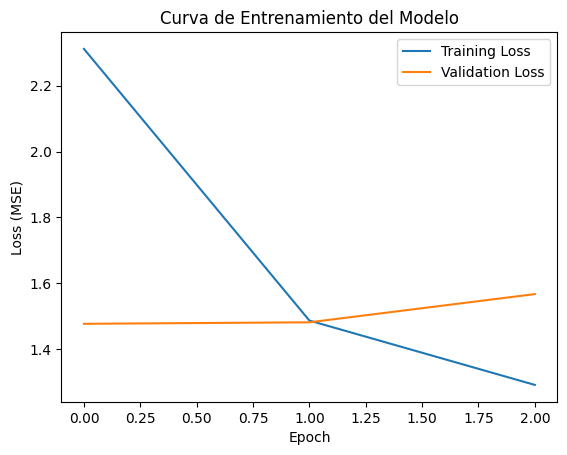

431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Valor Final de RMSE: 1.1244
En promedio, el modelo esta fuera de rando por aproximadamente 1.12 estrellas.


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Graficamos la historia del entrenamiento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Curva de Entrenamiento del Modelo')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

#Usamos el RMSE como metrica de evaluación
predictions = model.predict([X_test_user, X_test_book, X_test_desc])

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Valor Final de RMSE: {rmse:.4f}')
print(f'En promedio, el modelo esta fuera de rango por aproximadamente {rmse:.2f} estrellas.')

8. Recomendacion/Predicción

In [36]:
import numpy as np
import pandas as pd

# Seleccionamos aleatoriamente un usuario
idx = np.random.randint(0, len(y_test))
target_user_id_internal = X_test_user[idx]
target_user_id_original = user_enc.inverse_transform([target_user_id_internal])[0]

print(f'👤 Usuario Elegido: {target_user_id_original}')
print('🔍 El agente esta analizando aleatoriamente 5 libros para este usuario ...\n')

# -Seleccionamos aleatoriamente 5 libros (candidatos)
random_indices = np.random.randint(0, len(y_test), 5)

candidate_books = []
candidate_descs = []
candidate_titles = []

for i in random_indices:
    candidate_books.append(X_test_book[i]) # 'Book ID'
    candidate_descs.append(X_test_desc[i]) # 'Description'

    raw_title = book_enc.inverse_transform([X_test_book[i]])[0]
    clean_title = raw_title.replace('_', ' ').title()
    candidate_titles.append(clean_title)

# Preparamos los datos para el Modelo
# Repatimos el mismo User ID 5 veces (esto porque es el mismo usuario buscando 5 libros)
user_input_batch = np.array([target_user_id_internal] * 5)
book_input_batch = np.array(candidate_books)
desc_input_batch = np.array(candidate_descs)

# Predecimos los ratings para los 5 libros
predictions = model.predict([user_input_batch, book_input_batch, desc_input_batch])

# Elegimos el libro ganador, el que tiene el rating mas alto
best_book_idx = np.argmax(predictions)

# Mostramos los candidatos y el ganador
print(f'{'Book Title':<50} | {'Predicted Rating'}')
print("-" * 70)

for i in range(5):
    title = candidate_titles[i]
    score = predictions[i][0]


    if i == best_book_idx:
        print(f'🌟 {title:<47} | {score:.2f} (Libro Ganador)')
    else:
        print(f'   {title:<47} | {score:.2f}')

print("\n" + "="*30)
print(f"✅ Recomendacion Final del Agente: Tu deberias leer '{candidate_titles[best_book_idx]}'")
print("="*30)

👤 Usuario Elegido: AVZO523PH9I81
🔍 El agente esta analizando aleatoriamente 5 libros para este usuario ...

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Book Title                                         | Predicted Rating
----------------------------------------------------------------------
   Of Mice And Men (Penguin Audiobooks)            | 4.52
   Resurrection Day                                | 4.12
   Inquest On The Shroud Of Turin: Latest Scientific Findings | 4.34
   You Can'T Go Home Again                         | 4.02
🌟 The Mayor Of Casterbridge (Signet Classical Books) | 4.53 (Libro Ganador)

✅ Recomendacion Final del Agente: Tu deberias leer 'The Mayor Of Casterbridge (Signet Classical Books)'
